# Задание 5
(5 баллов)

In [ ]:
import numpy as np
from numpy.linalg import svd
from scipy.linalg import eigh
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

## Введение

Мы поработаем со статьёй [Joint-Embedding vs Reconstruction:
Provable Benefits of Latent Space Prediction
for Self-Supervised Learning](https://arxiv.org/pdf/2505.12477), воспроизведём эксперимент и сделаем собственные выводы, основываясь на теоретических результатах авторов.

Извлечение наиболее информативных признаков важная подзадача. В supervised learning её решают путём назначения меток, которые кодируют то, что считается информативным в данных. Часто такие метки имеют слишком узкую область использования, так как слишком специализированы и не подходят для нескольких downstream задач одновременно. В этой парадигме проявление SSL, как методов не полагающих, что априори считается информативным в данных, оказалось очень полезным. В SSL определяют какие вариации данных неинформативны и требуют игнорирования. По сути, задачи, связанные с естественными изображениями, такие как распознавание и сегментация, устойчивы к незначительным изменениям цвета и освещённости.

Рассмотрим два семейства методов на основе этого принципа: reconstruction-based и joint-embedding. Постараемся понять, в каких случаях лучше применять одни, а в каких - другие. Но для начала определим модель данных, с которой работаем, и выпишем решение для случая обучения с учителем.

### Data Model

Пусть наблюдаемые признаки состоят из двух частей: важных компонент ($\mathrm{x}$) и побочного ($\gamma$) сигналов (important features vs irrelevant noise):
$$
\mathrm{\~{x}}_i = \mathrm{x}_i + \mathrm{\gamma}_i, \quad \gamma_i \sim \mathcal{N}(0, \Gamma),
$$
имеем $n$ зашумленных примеров $\mathrm{\~{X}} = (\mathrm{\~{x}}_1, \dots, \mathrm{\~{x}}_n)^\top \in \mathbb{R}^{n \times d}$ 
и разметку $Y = (\mathrm{y}_1, \dots, \mathrm{y}_n)^\top \in \mathbb{R}^{n \times l}$.
Предположим, что разметка есть функция от "чистой" выборки $\mathrm{X} = (\mathrm{x}_1, \dots, \mathrm{x}_n)^\top$, $\mathrm{y_i} = g(\mathrm{x_i})$.

Распределение аугментаций запишем так:
$$
\forall \alpha \geq 0, \mathcal{T}(\alpha) := 
\{
    \tau: \mathbb{R}^d \rightarrow \mathbb{R}^d \; | \;
    \tau(\mathrm{x}) = \mathrm{x} + \theta + \alpha \gamma, \;
    \theta \sim \mathcal{N} (0, \Theta), \;
    \gamma \sim \mathcal{N} (0, \Gamma)
\},
$$
где  $\theta$ и $\gamma$ независимы, параметр $\alpha$ контролирует, насколько сильно аугментация "выравнена" с побочным сигналом $\gamma$.

Пусть сингулярное разложение для чистых данных $X = \mathrm{LKQ}^\top$. Будем считать, что ковариации шумов диагонализуются в базисе признаков:
$ \Gamma = \mathrm{Q} \Lambda_\Gamma \mathrm{Q}^\top, \Theta = \mathrm{Q} \Lambda_\Theta \mathrm{Q}^\top$. Это позволит  нам наглядно сравнить решения в «чистом» и «зашумлённом» сценариях.

Для аугментированных данных $\tau(\mathrm{x_i})$ = $\mathrm{x_i} + \theta + \alpha \gamma $,
где  $\theta \sim \mathcal{N}(0, \Theta) ,  \gamma \sim \mathcal{N}(0, \Gamma) $,
мат. ожидания по распределению аугментаций равны:
$$
\mathbb{E}_{\tau}[\tau(\mathrm{x_i})] = \mathrm{x_i}, \qquad
\mathbb{E}_{\tau}[\tau(\mathrm{x_i})\tau(\mathrm{x_i})^\top] = \mathrm{x_i} \mathrm{x_i}^\top + \Theta + \alpha^2 \Gamma
$$


### Supervised
Для начала рассмотрим линейную модель $ f_\mathrm{V}: \mathrm{x} \rightarrow \mathrm{V} \mathrm{x}, \; \mathrm{V} \in \mathbb{R}^{l \times d} $, и функцию потерь с учетом аугментаций:
$$
\mathcal{L}(\mathrm{V}) = \frac{1}{n}\sum_{i=1}^n \mathbb{E}_{\tau\sim \mathcal{T}} \| \mathrm{y_i} - \mathrm{V} \tau(\mathrm{x_i}) \|_2^2
$$
Выпишем градиент по $\mathrm{V}$:
$$
\nabla_\mathrm{V} \mathcal{L}(\mathrm{V}) = - \frac{2}{n} Y^\top X + 2 \mathrm{V}(A + \Theta + \alpha^2 \Gamma),
$$
где $ \mathrm{A} = \frac{1}{n} \mathrm{X}^\top \mathrm{X} $.
И получим оптимальное решение:
$$
\mathrm{V}^\star = \frac{1}{n} \mathrm{Y}^\top \mathrm{X} (\mathrm{A} + \Theta + \alpha^2 \Gamma)^{-1} 
$$
Реализуйте выписанное аналитическое решение в следующей ячейке (`supervised_probe_with_aug_closed_form`):

In [ ]:
def supervised_probe_with_aug_closed_form(X, Y_onehot, Theta_diag, Gamma_diag, alpha, eps=1e-10):
  """
  X: матрица признаков размера n x d.
  Y_onehot -  One-hot представление меток классов (n x l).
  Theta_diag - Диагональ матрицы Theta (ковариация аугментации). Элементы соответствуют всем d признакам.
        В статье Theta моделирует стохастическую часть аугментации.
  Gamma_diag - Диагональ матрицы Γ (ковариация шумовых компонент) для всех d признаков.
        По условию статьи первые k компонентов (signal) имеют нулевые λ_Γ, а шумовые компоненты — > 0.
  alpha - Параметр выравнивания (alignment) — масштабирует вклад шумовой ковариации в аугментации.
  """
  pass
  #return mse

Теперь возьмемся за аналитические решения для reconstruction и joint-embedding подходов.

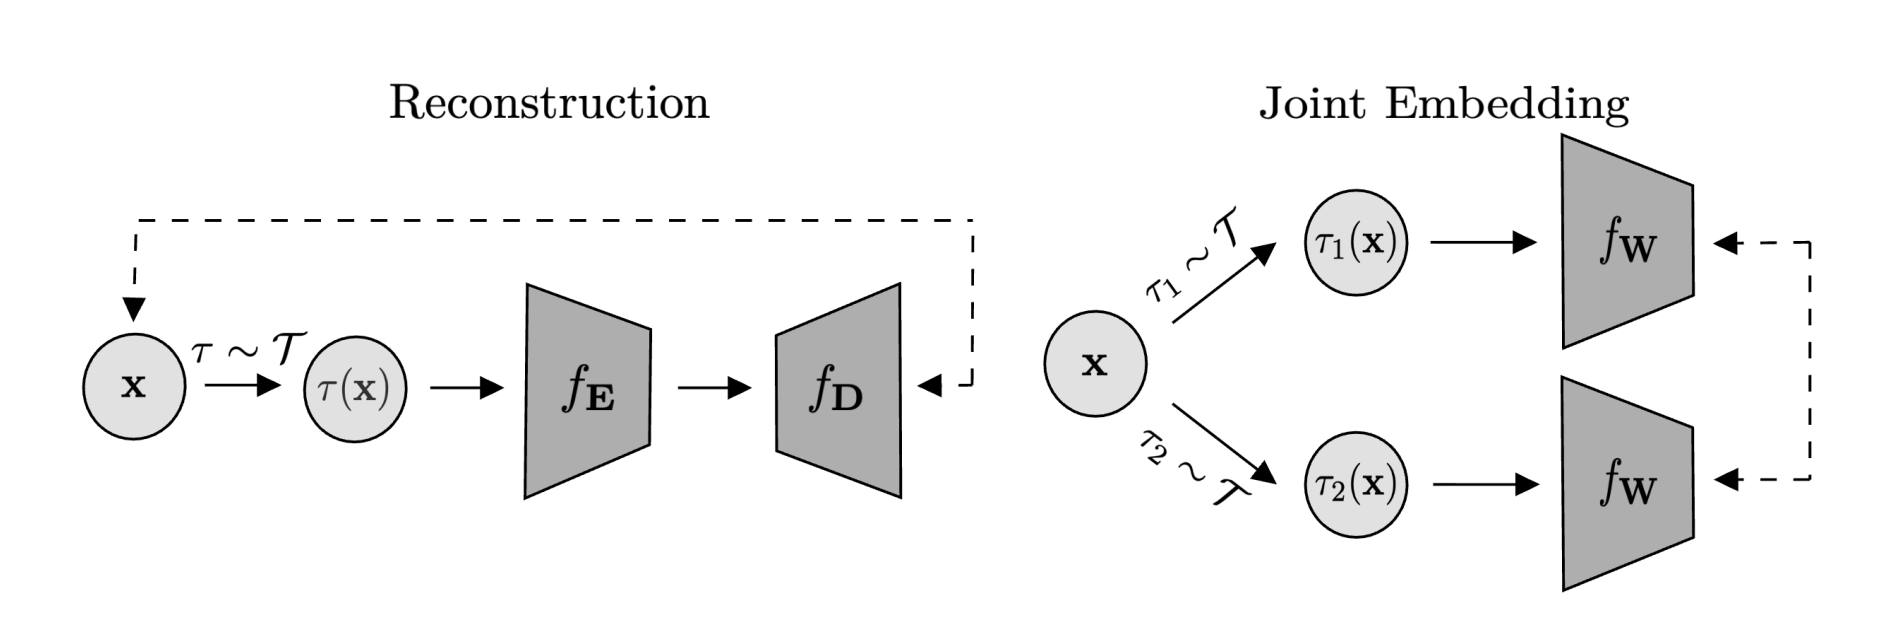


На картинке представлено различие двух подходов.

$\mathrm{x}$ - исходное изображение

$\mathrm{\tau}$ - случайная аугментация из семейства $\mathcal{T}$

$\tau_1$, $\tau_2$  - разные случайные аугментации из семейства $\mathcal{T}$

$\mathrm{f_{\text{E}}}$ - кодировщик

$\mathrm{f_{\text{D}}}$ - декодировщик

*Reconstruction*


На вход кодировщику $\mathrm{f_{\text{E}}}$ приходит аугментация $\tau(x)$ исходного изображения $\mathrm{x}$. Декодировщик $\mathrm{f_{\text{D}}}$ пытается восстановить исходное изображение $\mathrm{x}$ из закодированного вектора преобразованного изображения $\tau(x)$.


*Joint Embedding*


На вход двум одинаковым кодировщикам $\mathrm{f_{\text{E}}}$ приходят разные аугментации $\tau_1(\mathrm{x})$, $\tau_2(\mathrm{x})$ исходного изображения $\mathrm{x}$. Пытаясь кодировать аугментации одного и того же исходного изображения $\mathrm{x}$ в близкие по метрике вектора, кодировщих в то же время "расталкивает" вектора для разных исходных изображений (делая их далёкими по метрике).


Введём вспомогательные функции:

In [3]:
def symmetric_matrix_power(A, power, eps=1e-12):
  vals, vecs = eigh(A)
  vals = np.clip(vals, eps, None)
  return (vecs * (vals ** power)) @ vecs.T

def inv_sqrt(A):
  return symmetric_matrix_power(A, -0.5)

Теперь выпишем решения для задач с аугментациями.


Будем работать с линейной моделью: $f_\mathrm{E}: \mathrm{x} \rightarrow \mathrm{E} \mathrm{x}$, $f_\mathrm{D}: \mathrm{x} \rightarrow \mathrm{D} \mathrm{x}$.

Согласно Теореме 3.1 (из статьи) воспроизведём оптимальное Reconstruction-Based решение для кодировщика:

$\frac{1}{\mathrm{n}}\:\overline{\mathrm{X}}^⊤\:\overline{\mathrm{X}}(\frac{1}{\mathrm{n}}\:\overline{\mathrm{X}}^⊤\:\overline{\mathrm{X}} + \mathrm{\Sigma})^{−\frac{1}{2}} = \mathrm{RFP^T}$,

$\mathrm{E}^\star = \mathrm{T}\:\mathrm{P}^\mathrm{⊤_k} (\frac{1}{n}\:\overline{X}^⊤\:\overline{X} + \mathrm{\Sigma})^{−\frac{1}{2}}$

возьмём $\mathrm{T = I}$, где $\mathrm{P_k}$ - первые $k$ столбцов $\mathrm{P}$


здесь $\overline{\mathrm{x_i}}:= \mathbb{E}_{\tau \sim T}[\tau(\mathbb{x_i})]$ для каждого $i$, т.е. $\overline{\mathrm{X}}:= (\overline{\mathrm{x_1}}, \dots, \overline{\mathrm{x_n}})^\mathrm{T}$, 

$\Sigma$ - ковариация аугментированных данных, 

$$
\Sigma := \frac{1}{n} \sum_{i=1}^{n}
\mathbb{E}_{\tau \sim T}[\tau(\mathrm{x_i})\tau(\mathrm{x_i})^{\top}]
-
\mathbb{E}_{\tau \sim T}[\tau(\mathrm{x_i})] \; \mathbb{E}_{\tau \sim T}[\tau(\mathrm{x_i})]^{\top}
$$

Реализуйте выписанное решение для Reconstruction подхода в следующей ячейке.

In [ ]:
def reconstruction_encoder_closedform(X, Sigma_aug, k):
  pass
  #return E_star

Линейная модель для Joint-Embedding (JE) подхода: $f_\mathrm{W} = \mathrm{x} \rightarrow \mathrm{W} \mathrm{x}$.

Согласно Теореме 3.2 воспроизведём оптимальное Joint-Embedding-Based решение:

$\mathrm{W^\star} = \mathrm{U}\mathrm{Q_k^T}\mathrm{S}^{-\frac{1}{2}}, $

где $\mathrm{Q_k}$ - первые $k$ столбцов $\mathrm{Q}$, $\mathrm{U}$ - любая ортогональная матрица $k \times k$.

Реализуйте выписанное решение для JE подхода в следующей ячейке.

In [5]:
def joint_embedding_encoder_closedform(X, Sigma_aug, k):
  pass
  #return W_star

Для оценки качества решения также воспользуемся MSE:

$\min_{\mathrm{V} \in \mathbb{R}^{l \times k}}\;\frac{1}{n} \sum_{i \in ||n||} \; ||\mathrm{y_i} - \mathrm{V}\mathrm{z_i}||_2^2, $

где $\mathrm{z_i}$:

$\mathrm{z_i} = \mathrm{W}^\star \mathrm{x_i}\;\;\;$ для  joint-embedding модели

$\mathrm{z_i} = \mathrm{E}^\star \mathrm{x_i}\;\;\;$ для reconstruction модели  

In [7]:
def supervised_linear_probing_loss(Z, Y_onehot,alpha_reg=1e-3, eps=1e-8):
  ZZ = Z.T @ Z
  V = np.linalg.solve(ZZ + eps * np.eye(ZZ.shape[0]), Z.T @ Y_onehot).T
  preds = Z @ V.T
  mse = np.mean(np.sum((Y_onehot - preds) ** 2, axis=1))
  return mse


Теперь перечитаем секцию 4.1 Data, Noise and Augmentation и придумаем, как получить `X_clean, X_corrupt`, который будет представлять "повреждённые" гауссовским шумом входные данные.
Напишите функцию `generate_noisy_views`, которая зашумляет "чистые" данные в соответствии с переданной $\Lambda_\Gamma$.

In [ ]:
def generate_noisy_views(X_signal, n_signal, n_noise, lambda_Gamma_vals, alpha, rng):
    pass
    #return X_clean, X_corrupt

Итак, перейдём к проведению эксперимента, представленного на Figure 3.
Наша цель &mdash; понять насколько решение на зашумленных данных `X_corrupted` отклоняется от оптимального на чистых данных `X_clean` при различной интенсивности шума ($\lambda^\Gamma_{max}$) и разной степенью "выровненности" аугментаций ($\alpha$) в 3 сценариях обучения (Supervised, Reconstruction, JE).

Рассмотрим аугментации со слабым ($\lambda^\Gamma_{max} = 10^3$) и сильным ($\lambda^\Gamma_{max} = 10^6$) шумом и разной степенью "выравнивания" с ним (слабым ${\alpha = 0.1}$, средним $\alpha = 1$ и сильным $\alpha = 10$). Заметим, что для того, чтобы оценить влияние уровня шума во входных данных мы фиксируем $\lambda^\Theta_{max} = 10^4$ и варьируем значение $\lambda^\Gamma_{max}$.

**!** Реализуйте функцию `def run(...):` (которая соответствует Section С [статьи](https://arxiv.org/pdf/2505.12477)), подтверждающую экспериментально теоретические результаты  Section 4.

В `def run(...)` мы хотим 

1. Формируем чистый сигнал Х с помощью PCA отбираем первые 50 главных компонент.
2. Кодируем `y` через OneHotEncode, 
3. Добавляем шум (получаем `X_corrupt`) через спектры матриц ковариации $\Theta$ и $\Gamma$, через $\alpha$ (`generate_noisy_views`),
4. Строим матрицу `Sigma_aug` 
5. Находим оптимальные решения и ошибки (используя `supervised_linear_probing_loss`) через аналитическую формулу для каждого семества методов: 
    - Supervised, 
    - Reconstruction, 
    - Joint-Embedding.
6. Смотрим как выровненность ($\alpha$) и интенсивность ($\lambda^\Gamma$) аугментаций отдаляют решение от полученного на чистых данных.

`Sigma_aug` - ковариационная матрица аугментированных данных. Она описывает, насколько варьируются признаки данных после применения случайной аугментации $\tau$.

Для нашего эксперимента с гауссовскими аугментациями 

$$
Cov[\tau(\mathrm{x})]_{\tau} = \Theta +\alpha^2\Gamma 
$$

Поэтому $\Sigma_{aug} = \Theta + \alpha^2 \Gamma$.

Помним, что эксперимент мы проводим для различных $\lambda^\Gamma_{max}$ и размера выборки, так что перед обработкой данных нужно создать подвыборку исходного датасета нужного размера.

In [ ]:
def run(X_raw, y,
        n_signal=50, n_noise=50,
        lambda_theta_max=1e4,
        lambda_gamma_max_values=(1e3, 1e6),
        alphas=(0.1, 1.0, 10.0),
        n_list=(100, 216, 464, 1000, 2154, 4642, 10000, 21544, 46416, 60000),
        seeds=3):
  # do PCA of X_raw

  # OneHotEncode of y

  results = {}

  d = n_signal + n_noise

  for lambda_gamma_max in lambda_gamma_max_values:
    for seed in range(seeds):
      # Генерируем случайные lambda_Gamma_vals и lambda_Theta_vals

      for alpha in alphas:
        # формируем Sigma_aug

        for n in n_list:

          # Создаём подвыборку нужного размера

          X_clean, X_corrupt = generate_noisy_views(
              Xs, n_signal, n_noise, lambda_Gamma_vals, alpha, rng
          )

          # Supervised

          # Joint embedding

          # Reconstruction

          key = (lambda_gamma_max, alpha, n)

          results[key]["sup"].append(diff_sup)
          results[key]["je"].append(diff_je)
          results[key]["rc"].append(diff_rc)

  averaged = {k: {m: np.mean(v) for m, v in vals.items()} for k, vals in results.items()}
  return averaged

Теперь воспроизведём эксперимент на датасете MNIST. Воспользуемся `torchvision.datasets` для его получения, получим результаты эксперимента с помощью нашей функции `run(...)`.

In [ ]:
from torchvision.datasets import MNIST
from torchvision import transforms
mnist = MNIST(root='data', train=True, download=True, transform=transforms.ToTensor())
X_raw = mnist.data.numpy().reshape(len(mnist), -1).astype(np.float32)
y = mnist.targets.numpy()

n_list = np.logspace(2, 5, 10)

100%|██████████| 9.91M/9.91M [00:00<00:00, 22.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 623kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 5.71MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.74MB/s]


In [ ]:
averaged = run(X_raw, y,
                n_signal=50, n_noise=50,
                lambda_theta_max=1e4,
                lambda_gamma_max_values=(1e3, 1e6),
                alphas=(0.1, 1.0, 10.0),
                n_list=n_list,
                seeds=5)


Визуализируем результат

In [ ]:
import matplotlib.pyplot as plt
noise_regimes = [1e3, 1e6]
methods = ["sup", "je", "rc"]
method_titles = ["Supervised", "Joint-Embedding", "Reconstruction"]
alphas = [ 0.1, 1.0, 10.0]
n_list = n_list

fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex=True, sharey=True)

for i, lambda_g in enumerate(noise_regimes):
  for j, method in enumerate(methods):
    ax = axes[i, j]
    lines = []
    for alpha in alphas:
        xs = []
        ys = []
        for n in n_list:
            key = (lambda_g, alpha, n)
            if key in averaged:
                xs.append(n)
                ys.append(averaged[key][method])
        if len(xs):
            line, = ax.plot(xs, ys, marker='o', label=f"alpha={alpha}")
            lines.append(line)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel("sample size n")
    if j == 0:
        ax.set_ylabel("|MSE_clean - MSE_corrupt|")
    ax.set_title(fr"Noise $\lambda^{{\Gamma}}_{{max}}={lambda_g:.0f}$ {method_titles[j]}")
    ax.grid(True, which='both', ls=':', linewidth=0.5)

    ax.legend(handles=lines, title='Alpha values', loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()

Исходя из полученных результатов, какие выводы мы можем сделать?



Насколько эти выводы совпадают с выводами авторов статьи? (секция 5.1 Experiments With Linear Models)

Supervised:

Reconstruction:

Joint-Embedding: